In [1]:
import sys

import numpy as np
import pickle
import os
import pandas as pd
from scipy import sparse

import time

import scanpy
import numpy as np

import torch
from torch import optim

import model_lord

import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import anndata as ad
import gc



/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
skin_rnaPath='/data/xinyi/shareseq/skin_rna.h5ad'
skin_rna=scanpy.read(skin_rnaPath)

skin_atacPath='/data/xinyi/shareseq/skin_atac.h5ad'
skin_atac=scanpy.read(skin_atacPath)

In [3]:
skin_atac.var['index']=np.arange(skin_atac.shape[1])

In [4]:
scanpy.pp.filter_genes(skin_rna, min_cells=300)
scanpy.pp.filter_genes(skin_atac, min_cells=300)

scanpy.pp.filter_cells(skin_atac, min_genes=300)
scanpy.pp.filter_cells(skin_rna, min_genes=300)
skin_atac=skin_atac[skin_rna.obs.index]

scanpy.pp.filter_genes(skin_rna, min_cells=300)
scanpy.pp.filter_genes(skin_atac, min_cells=300)
scanpy.pp.filter_cells(skin_atac, min_genes=300)
scanpy.pp.filter_cells(skin_rna, min_genes=300)
skin_atac=skin_atac[skin_rna.obs.index]


atac=skin_atac.X.toarray()
rna=skin_rna.X.toarray()

atac_posweight=(atac.size-np.sum(atac))/np.sum(atac)
rna_posweight=(rna.size-np.sum(rna))/np.sum(rna)

/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [5]:
log_data=True
normalize='minmax'
hiddenSize=1024
sharedSize=50
dSpecificSize=20

In [6]:
#train-test split
np.random.seed(3)
pctVal=0.05
pctTest=0.1

allIdx_all=np.arange(atac.shape[0])
np.random.shuffle(allIdx_all)
valIdx_all=allIdx_all[:int(pctVal*atac.shape[0])]
testIdx_all=allIdx_all[int(pctVal*atac.shape[0]):(int(pctVal*atac.shape[0])+int(pctTest*atac.shape[0]))]
trainIdx_all=allIdx_all[(int(pctVal*atac.shape[0])+int(pctTest*atac.shape[0])):]


In [7]:
#preprocess
if log_data:
    rna=np.log(rna+1/2)
    atac=np.log(atac+1/2)
if normalize=='zscore':
    scaler_rna = StandardScaler()
    scaler_rna.fit(rna[trainIdx_all])
    rna=scaler_rna.transform(rna)
    
    scaler_atac = StandardScaler()
    scaler_atac.fit(atac[trainIdx_all])
    atac=scaler_atac.transform(atac)
elif normalize=='minmax':
    rna=(rna-np.min(rna,axis=1,keepdims=True))/(np.max(rna,axis=1,keepdims=True)-np.min(rna,axis=1,keepdims=True))
    atac=(atac-np.min(atac,axis=1,keepdims=True))/(np.max(atac,axis=1,keepdims=True)-np.min(atac,axis=1,keepdims=True))

In [8]:
#preprocess for de
skin_rna_de=skin_rna.copy()
scanpy.pp.normalize_total(skin_rna_de, target_sum=1e4)
scanpy.pp.log1p(skin_rna_de)
scanpy.pp.scale(skin_rna_de,zero_center=False)

skin_atac_de=skin_atac.copy()
scanpy.pp.normalize_total(skin_atac_de, target_sum=1e4)
scanpy.pp.log1p(skin_atac_de)
scanpy.pp.scale(skin_atac_de,zero_center=False)

In [9]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 

batchsize=512
saveFreq=100
epochs=10000
weight_decay=0
seed=3

dropout=0.01


testSaveName='shareseq_lord'
name='randNoise_sharedRecon_bceWweight_bce_morefilter'
modelsavepath_lord=os.path.join('/data/xinyi/shareseq/results/models',testSaveName,name)

nFeatures_rna=rna.shape[1]
nFeatures_atac=atac.shape[1]


train_nodes_idx=trainIdx_all
val_nodes_idx=valIdx_all

loadEpoch_decoders='4900'
loadEpoch_encoders='3900'

In [10]:
celltype_unique,celltype_labels,celltype_counts=np.unique(skin_atac.obs['celltype'][train_nodes_idx],return_counts=True,return_inverse=True)




### load DE

In [11]:
plotsavepath_de=os.path.join('/data/xinyi/shareseq/results/plots/',testSaveName,name,'de')
nsamples=36

In [12]:

with open(os.path.join(plotsavepath_de,'de_shared_all_centered_2bins_rna'), 'rb') as output:
    deShared_centered_2bins_rna=pickle.load(output)
with open(os.path.join(plotsavepath_de,'de_d_all_centered_2bins_rna'), 'rb') as output:
    deD_centered_2bins_rna=pickle.load(output)
    
with open(os.path.join(plotsavepath_de,'de_shared_all_centered_2bins_heldout_rna'), 'rb') as output:
    deShared_centered_2bins_heldout_rna=pickle.load(output)
with open(os.path.join(plotsavepath_de,'de_d_all_centered_2bins_heldout_rna'), 'rb') as output:
    deD_centered_2bins_heldout_rna=pickle.load(output)


In [105]:

with open(os.path.join(plotsavepath_de,'de_shared_all_centered_2bins_atac'), 'rb') as output:
    deShared_centered_2bins_atac=pickle.load(output)
with open(os.path.join(plotsavepath_de,'de_d_all_centered_2bins_atac'), 'rb') as output:
    deD_centered_2bins_atac=pickle.load(output)
    
with open(os.path.join(plotsavepath_de,'de_shared_all_centered_2bins_heldout_atac'), 'rb') as output:
    deShared_centered_2bins_heldout_atac=pickle.load(output)
with open(os.path.join(plotsavepath_de,'de_d_all_centered_2bins_heldout_atac'), 'rb') as output:
    deD_centered_2bins_heldout_atac=pickle.load(output)


### setup go

In [14]:
### enrichment using goatools adapted from https://github.com/mousepixels/sanbomics_scripts/blob/main/GO_in_python.ipynb
from genes_ncbi_human_proteinCoding import GENEID2NT as GeneID2nt_hs

In [15]:
from goatools.base import download_go_basic_obo
from goatools.base import download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

In [16]:
obo_fname = download_go_basic_obo()
fin_gene2go = download_ncbi_associations()
obodag = GODag("/data/xinyi/shareseq/go-basic.obo")

  EXISTS: go-basic.obo
  EXISTS: gene2go
/data/xinyi/shareseq/go-basic.obo: fmt(1.2) rel(2023-07-27) 46,356 Terms


In [17]:
mapper = {}

for key in GeneID2nt_hs:
    mapper[GeneID2nt_hs[key].Symbol] = GeneID2nt_hs[key].GeneID
    
inv_map = {v: k for k, v in mapper.items()}

In [18]:
# Read NCBI's gene2go. Store annotations in a list of namedtuples
objanno = Gene2GoReader(fin_gene2go, taxids=[9606])
# Get namespace2association where:
#    namespace is:
#        BP: biological_process               
#        MF: molecular_function
#        CC: cellular_component
#    assocation is a dict:
#        key: NCBI GeneID
#        value: A set of GO IDs associated with that gene
ns2assoc = objanno.get_ns2assc()

HMS:0:00:03.167180 343,513 annotations, 20,757 genes, 18,851 GOs, 1 taxids READ: gene2go 


In [19]:
ns2assoc={'BP':ns2assoc['BP']}

In [20]:
goeaobj = GOEnrichmentStudyNS(
        GeneID2nt_hs.keys(), # List of mouse protein-coding genes
        ns2assoc, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method


Load BP Ontology Enrichment Analysis ...
 82% 16,989 of 20,651 population items found in association


In [21]:
#run one time to initialize
GO_items = []

temp = goeaobj.ns2objgoea['BP'].assoc
for item in temp:
    GO_items += temp[item]
    

# temp = goeaobj.ns2objgoea['CC'].assoc
# for item in temp:
#     GO_items += temp[item]
    

# temp = goeaobj.ns2objgoea['MF'].assoc
# for item in temp:
#     GO_items += temp[item]

In [22]:
def go_it(test_genes):
    print(f'input genes: {len(test_genes)}')
    
    mapped_genes = []
    for gene in test_genes:
        try:
            mapped_genes.append(mapper[gene])
        except:
            pass
    print(f'mapped genes: {len(mapped_genes)}')
    
    goea_results_all = goeaobj.run_study(mapped_genes)
    goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]
    GO = pd.DataFrame(list(map(lambda x: [x.GO, x.goterm.name, x.goterm.namespace, x.p_uncorrected, x.p_fdr_bh,\
                   x.ratio_in_study[0], x.ratio_in_study[1], GO_items.count(x.GO), list(map(lambda y: inv_map[y], x.study_items)),\
                   ], goea_results_sig)), columns = ['GO', 'term', 'class', 'p', 'p_corr', 'n_genes',\
                                                    'n_study', 'n_go', 'study_genes'])

    GO = GO[GO.n_genes > 1]
    return GO

### plotting - rna

In [141]:
plotsavepath_de_pc=os.path.join(plotsavepath_de,'byPC')
if not os.path.exists(plotsavepath_de_pc):
    os.mkdir(plotsavepath_de_pc)

In [142]:
pval_thresh=0.05
fc_thresh_rna_min=1.2
fc_thresh_rna_max=8
fc_interval_rna=0.2

maxPlot=15
minCount=0

dePC_shared_rna=20
dePC_d_rna=10

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
Nkrf
Khdrbs3
Lox
Ccdc124
Epm2a
Pla2g12a
Klf2
Mul1
Hsd17b10
Msi1
Lrrtm2
Zc3hc1
Fzd4
Tgif2
Tgm1


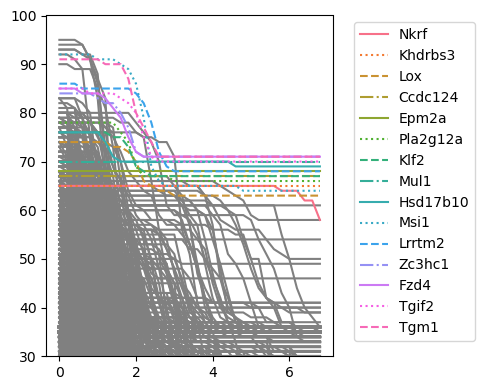

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
Ikzf2
Tprg
Krt77
Abca12
Skint1
Defb6
Skint5
Skint8
Adgrf2
Pkib
Lipm
Areg
Eps8l1
Skint6
Skint9


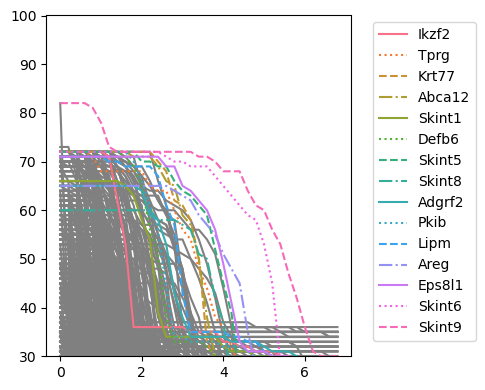

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
Slfn5
Col4a2
Dysf
Ebf3
Zeb2
Filip1
Col15a1
Pcolce
Plxnd1
Cacna2d1
Anxa3
Rin3
Ebf2
Col5a1
Zeb1


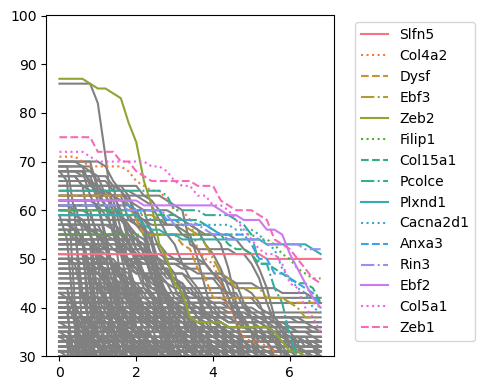

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
Tprkb
Pnkd
Gm26835
Inhba
C7
Dnajc19
Gpr176
Adgre5
Tgfb3
Zfp366
Galnt15
Polr1e
Tph2
Proser3
Leng1


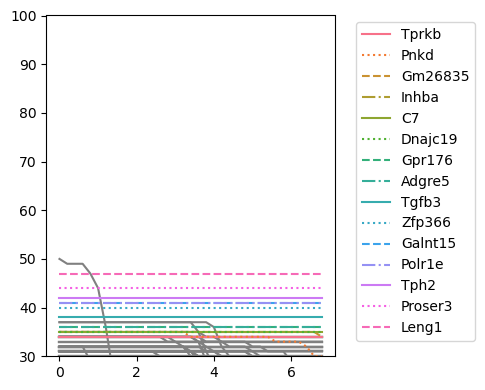

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
Stpg2
Tbx15
Ccdc137
Serpinb10
Sbk1
Ccdc15
Abca9
Bcl7b
Foxm1
Chaf1b
Wash1
Faim
Ska2
Tceb2
Pofut2


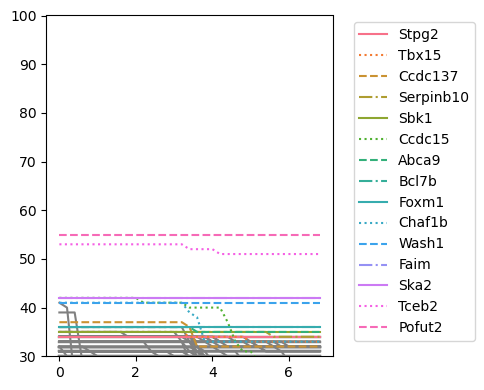

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
Gjb4
Zfp606
Fancd2
Slc16a13
Cd46
Faim
Trdmt1
Vldlr
Tuba1a
Ptcd1
BC003965
C130071C03Rik
Top1mt
Zfp958
Nle1


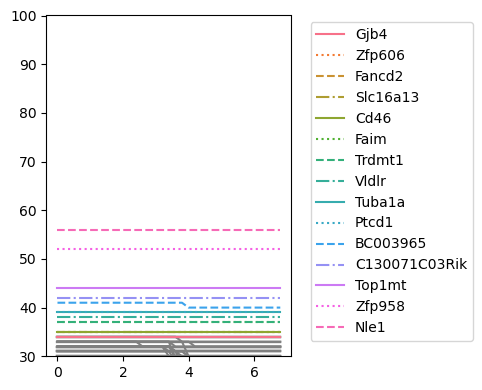

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
Pappa2
Lrp8
Ankrd54
Skint11
Smpdl3b
Serpinb7
Dkk2
Sf3a2
Stx2
Gen1
Mrps7
Mbd4
Cpxm2
Tmem184c
Vma21


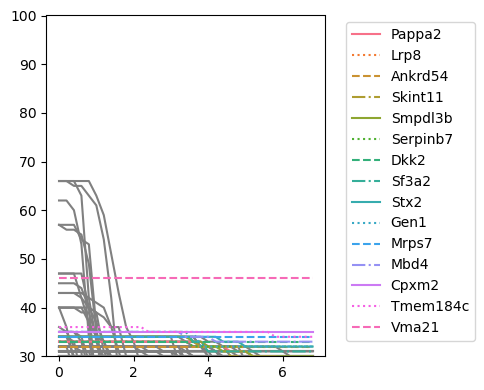

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
Zc3hc1
Ska1
Osbpl6
Pde1a
Mmrn2
Tspan13
Daam2
Prmt5
D2hgdh
Dfna5
Hacl1
Arl2bp
Vma21
Egfl7
Hsd17b10


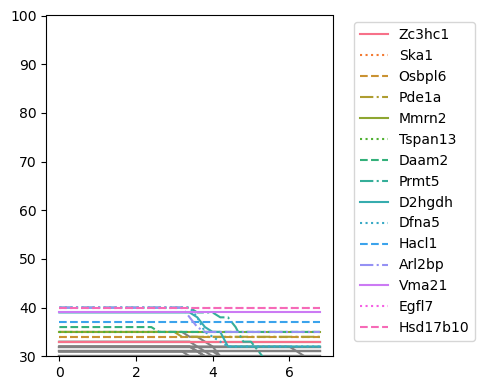

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
Asb8
Rpp14
Rcan2
Serpinb7
Depdc1a
Hectd3
Hacl1
Lsp1
Pus1
Mgat2
Stxbp1
Zbtb49
Clpp
Pdlim2
Stx19


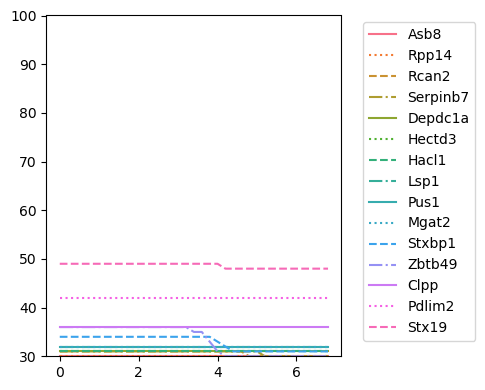

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
BC031181
Taf6
Timm50
Mrpl18
Galc
Tph2
Nutf2
Zbtb49
Stxbp1
Dlx4os
Spc24
Clpp
Itpa
Nup35
Pqlc3


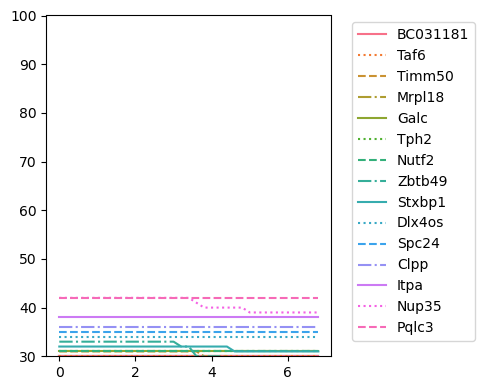

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
Acot1
Nid1
Setd6
Masp1
H2afz
Dhrs9
Fancd2
Abcc9
Ska2
Rad51ap1
Lmnb2
Trp73
Igf1
Slc46a2
Lvrn


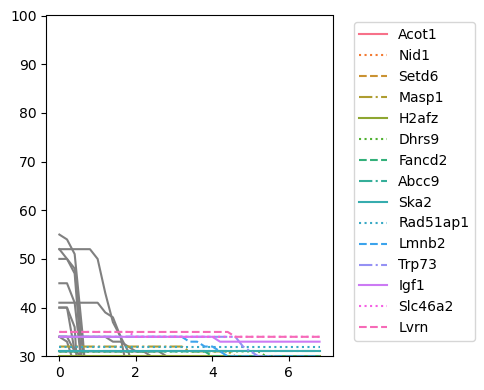

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
Trp53inp2
Ska1
Krt83
Tead4
Hist1h2bb
Clpp
Ogn
Cetn2
Phyh
Tgm1
Acot8
Nop16
Nsl1
Ndufb11
Nr2f2


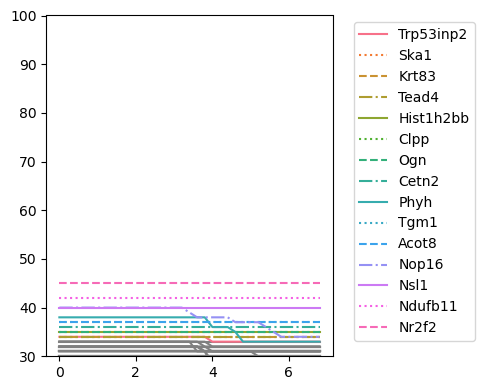

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
Gm38399
Med21
Adam33
Daam2
Serping1
Srm
Myrip
Pde2a
Cd93
Col5a3
Emcn
Amph
Mir155hg
Serpine2
Ap2m1


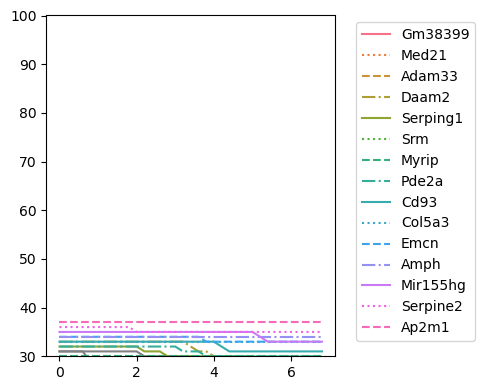

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
Ears2
Tfap4
Rpl15
Tmem178b
Cdk2ap1
Tma7
Foxm1
Traip
Tuba1b
Snrpb2
Pou6f1
Faim
Gpr19
Bhlhb9
4933404O12Rik


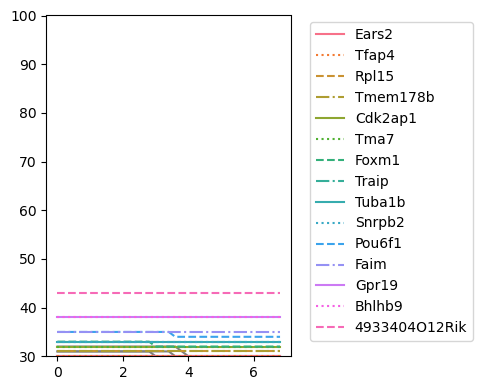

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
Ppil3
Pgls
Mir155hg
Gen1
Pnpla1
Serpinb7
Arhgap19
Traip
Mcam
Gtse1
Adck5
Acp2
Nsl1
Caskin2
Atp1b1


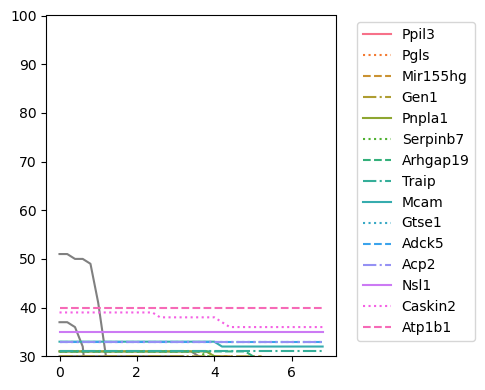

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
Rpa2
Tmem219
Grem1
Ccdc97
Cp
Gm20342
Rilpl1
Cdc34
Csmd2
Zfp958
Cyb561
Ndst2
Trmt44
Capns2
Hist1h2ai


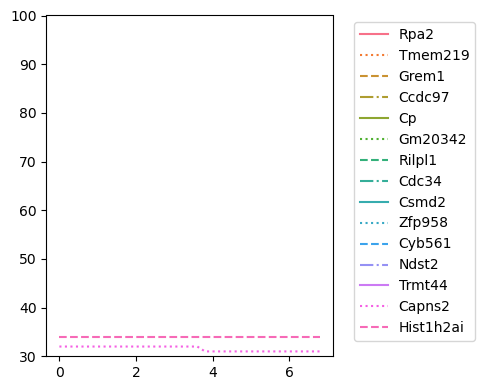

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
Decr2
Ccdc86
Ino80b
Fam118a
Bbs5
Cp
Nol12
Adi1
Abcc10
Kctd6
Cisd1
Hist1h2ai
Csmd2
Blvra
Abca9


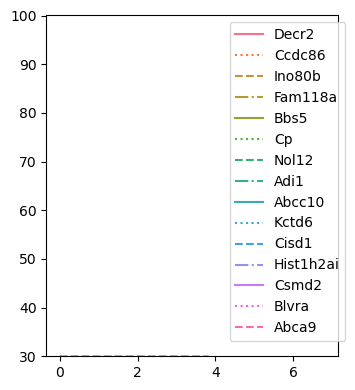

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
Tspan12
Pex6
Mtfr1l
Zfp830
Morc4
Vegfc
Trdmt1
S1pr1
Sephs2
Inpp5e
Ndufb8
Ttc9
Emcn
Itgbl1
Lrp8


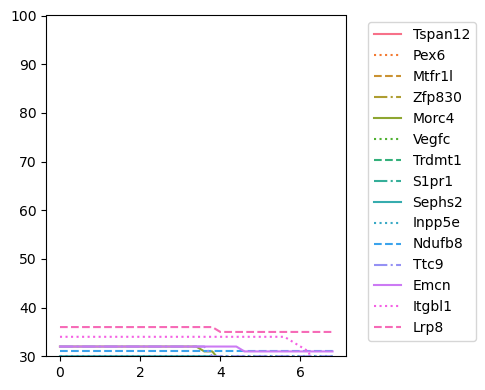

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
Hoxb5
5430421N21Rik
Arhgap27
Ano3
Vars2
Commd8
S1pr1
Hsd17b11
Rnf32
Grem1
2810417H13Rik
Nipal3
Hoxb5os
Pex6
Btbd2


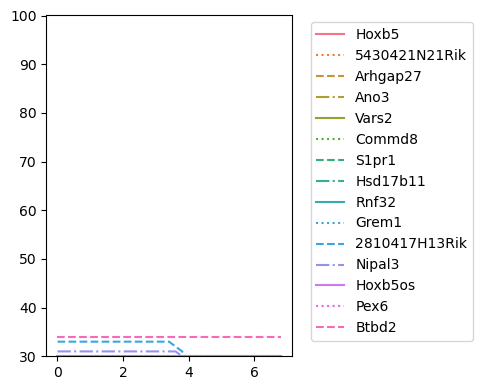

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
Rps23
Tmem104
Zcchc24
Mrpl32
Coil
Exosc9
Psmg1
Tuba1b
Adgra2
Tuba1a
Ndufa2
Timm17a
Wdr18
Hist1h2bb
Kctd6


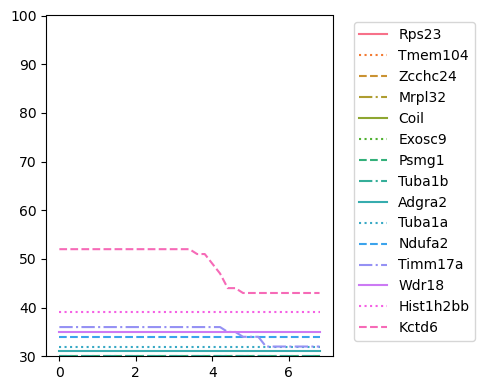

In [160]:
#also taking into account direction of fold change & plotting
colortest=sns.color_palette("husl", maxPlot)
linestyles=['solid','dotted','dashed','dashdot']
nFCsteps=int((fc_thresh_rna_max-fc_thresh_rna_min)/fc_interval_rna+1)
xrange=np.arange(nFCsteps)*fc_interval_rna
for pc_i in range(dePC_shared_rna):
    resDEsampling_rna_shared=np.zeros((nFCsteps,skin_rna_de.shape[1]))
    
    for fc_thresh_rna_idx in range(nFCsteps):
        print(fc_thresh_rna_idx)
        resLogFC={0:np.array([]),-1:np.array([]),1:np.array([])}
        resNames={0:np.array([]).astype(str),-1:np.array([]).astype(str),1:np.array([]).astype(str)}
        resAgreement={0:np.array([]).astype(str),-1:np.array([]).astype(str),1:np.array([]).astype(str)}
        fc_thresh_rna=fc_thresh_rna_min+fc_thresh_rna_idx*fc_interval_rna
        for h in range(nsamples):
            deRes_shared_centered=deShared_centered_2bins_rna[h]
            deRes_shared_centered_heldout=deShared_centered_2bins_heldout_rna[h]
            for deDirection in resLogFC.keys():
    #             print(deDirection)
                resNames_h_val=deRes_shared_centered[pc_i][str(deDirection)].names.to_numpy()[np.logical_and(deRes_shared_centered[pc_i][str(deDirection)].pvals_adj<pval_thresh,np.abs(deRes_shared_centered[pc_i][str(deDirection)].logfoldchanges)>np.log2(fc_thresh_rna))]
                resValues_h_val=deRes_shared_centered[pc_i][str(deDirection)].logfoldchanges.to_numpy()[np.logical_and(deRes_shared_centered[pc_i][str(deDirection)].pvals_adj<pval_thresh,np.abs(deRes_shared_centered[pc_i][str(deDirection)].logfoldchanges)>np.log2(fc_thresh_rna))]

                resNames_h_heldout=deRes_shared_centered_heldout[pc_i][str(deDirection)].names.to_numpy()[np.logical_and(deRes_shared_centered_heldout[pc_i][str(deDirection)].pvals_adj<pval_thresh,np.abs(deRes_shared_centered_heldout[pc_i][str(deDirection)].logfoldchanges)>np.log2(fc_thresh_rna))]
                resValues_h_heldout=deRes_shared_centered_heldout[pc_i][str(deDirection)].logfoldchanges.to_numpy()[np.logical_and(deRes_shared_centered_heldout[pc_i][str(deDirection)].pvals_adj<pval_thresh,np.abs(deRes_shared_centered_heldout[pc_i][str(deDirection)].logfoldchanges)>np.log2(fc_thresh_rna))]

                resNames_h,valIdx_h,heldoutIdx_h=np.intersect1d(resNames_h_val,resNames_h_heldout,return_indices=True)
                sameDir=np.equal(resValues_h_val[valIdx_h]>0,resValues_h_heldout[heldoutIdx_h]>0)
#                 print(resNames_h_val.size)
                resAgreement[deDirection]=np.concatenate((resAgreement[deDirection],resNames_h[sameDir]))
                for fidx in range(np.sum(sameDir)):
                    f=str(resNames_h[sameDir][fidx])
                    if f not in resNames[deDirection]:
                        resNames[deDirection]=np.concatenate((resNames[deDirection],[f]))
                        resLogFC[deDirection]=np.concatenate((resLogFC[deDirection],[resValues_h_val[valIdx_h[sameDir]][fidx]]))
                    else:
                        fidx_res=np.where(resNames[deDirection]==f)
                        resLogFC[deDirection][fidx_res]+=resValues_h_val[valIdx_h[sameDir]][fidx]
        for deDirection in resLogFC.keys():
            resNames_agree,resAgreement_counts=np.unique(resAgreement[deDirection],return_counts=True)

            _,shared_unique_idx,countIdx=np.intersect1d(skin_rna_de.var_names,resNames_agree,return_indices=True)
            
            resDEsampling_rna_shared[fc_thresh_rna_idx,shared_unique_idx]+=resAgreement_counts[countIdx]
    
    fig, ax = plt.subplots(figsize=(5, 4))
    plotorder=np.argsort(np.sum(resDEsampling_rna_shared,axis=0))
    lines=[]
    plotCount=0
    for gidx_ in range(skin_rna_de.shape[1]):
        gidx=plotorder[gidx_]

        if np.sum(resDEsampling_rna_shared,axis=0)[gidx]==0:
            continue
        if gidx_>=skin_rna_de.shape[1]-maxPlot:
            c=colortest[plotCount]
            print(skin_rna_de.var_names.to_numpy()[gidx])
            line_i,=ax.plot(xrange,resDEsampling_rna_shared[:,gidx],color=c,label=skin_rna_de.var_names.to_numpy()[gidx],linestyle=linestyles[plotCount%len(linestyles)])
            lines.append(line_i)
            plotCount+=1
        else:
            c='gray'
            ax.plot(xrange,resDEsampling_rna_shared[:,gidx],color=c)
#         plotCount+=1
    plt.ylim(30,100)
    ax.legend(handles=lines,bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.savefig(os.path.join(plotsavepath_de_pc,'rna_'+str(pc_i)+'shared_countsVSfc.pdf'))
    plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
Pnck
Grk5
Gm5860
Cpa2
Ticrr
9530052E02Rik
Gm2016
Dsn1
Nkiras1
March4
Xylb
Ptcd1
Rasgrp3
Ankrd60
Pls1


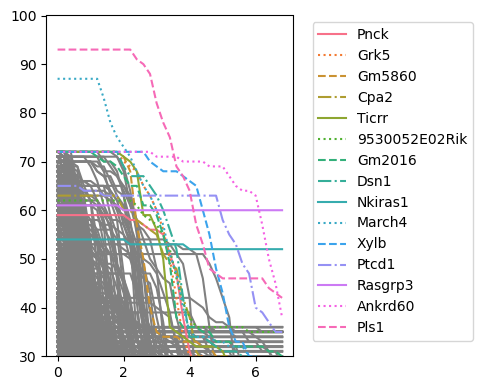

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
Kcnd2
Frem1
Jam2
Pold1
Sdpr
Rwdd1
Pbdc1
Pdgfra
Reck
Sec14l4
Herc6
Gm14236
Fgl2
Smdt1
Hist1h2ai


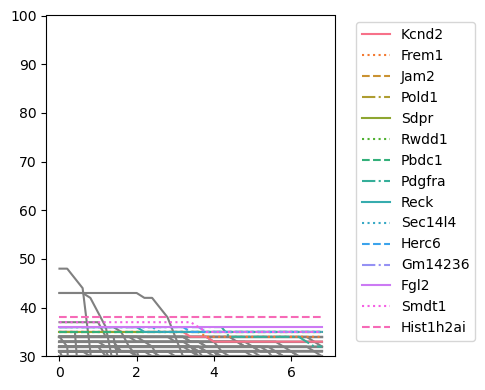

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
Wash1
Gm38392
Lockd
Kcnt2
Fam171a2
Grem1
Hist1h3b
Tnfrsf12a
Tgm5
Cbx2
Alg10b
Slc12a7
Kif20a
Bub1
Chmp7


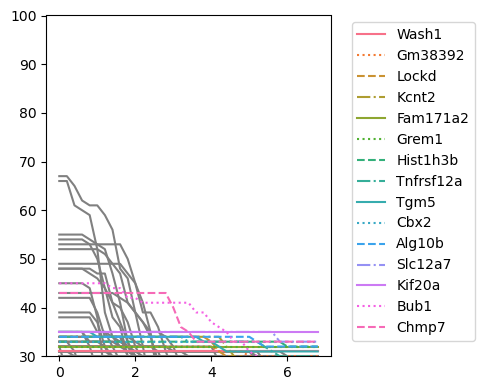

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
Pacrg
Smim20
Sema4g
Lmf2
Aurkb
Tspan3
Cntrob
Hs3st1
Mapk3
Foxo4
Ska1
Sfrp4
Tfb1m
Map9
H2afz


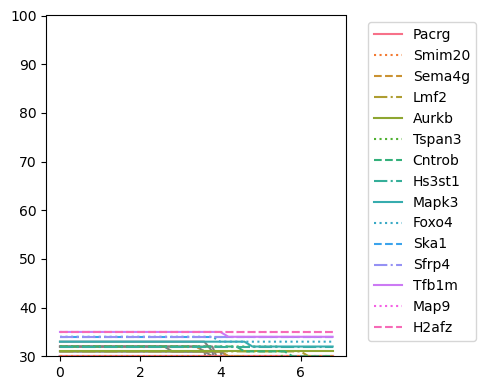

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
Fam219b
Wdr83
Tsga10
Amph
Emc8
Clstn2
Nrip3
Acox3
Fam73a
Has3
Fam83d
Zfp597
A930011G23Rik
Wdr19
Mcm10


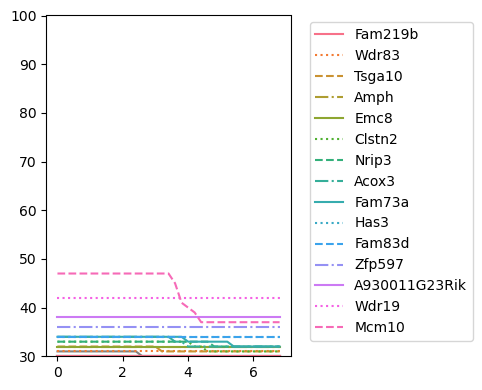

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
H2-T23
Sfrp4
Rgs5
Acta2
Pyroxd1
Nlrp1b
Atg9a
Fignl1
Troap
Rad54l
Tnfaip6
Abca9
Tyms
Krt83
Abcc9


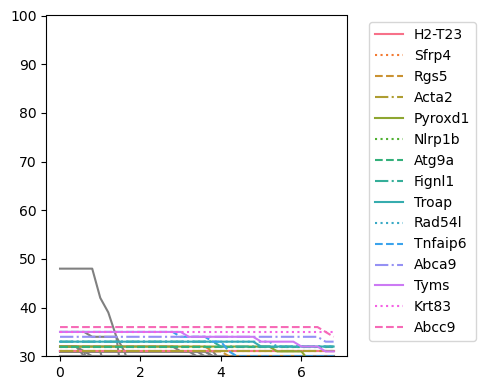

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
Fam160a1
Msx1
Gcnt1
Kcnq1
Pde3b
Gm4221
Csf1
Rspo4
Imp4
Synpr
Frem1
Gpr19
Ano4
Ska1
Esam


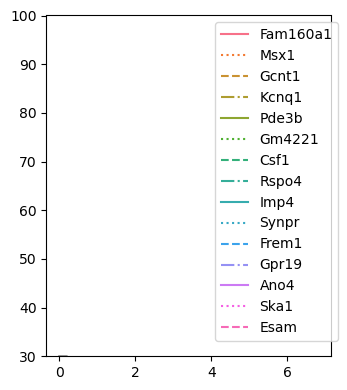

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
Bbip1
Dvl2
Lvrn
Tfb2m
Cldn34c1
Setd4
Hist1h2ai
Kcnab1
Fgf10
Hist1h4b
Pcolce
Fblim1
Slc18b1
Dhrs7b
Eid1


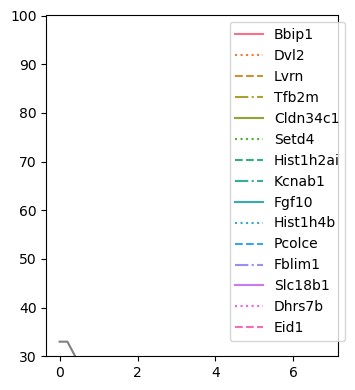

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
Dclk3
Rrp7a
Hmbs
Hspa12b
Gatsl2
Tfap4
Hist2h2ac
Foxred1
Plbd2
Hist1h4f
Hist1h4b
Tex30
Sap30l
Krt83
Gpx3


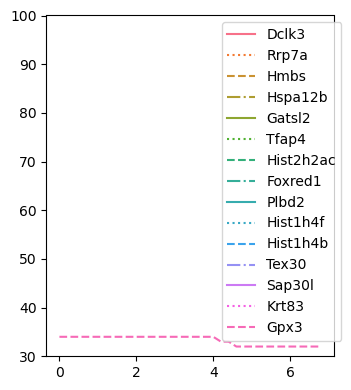

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
Itgb3bp
Gm20517
Krt83
Esam
Men1
Lvrn
Tti2
Scube1
F5
Slc26a11
Kdr
Slc18b1
Ska1
Hist1h4b
Nsl1


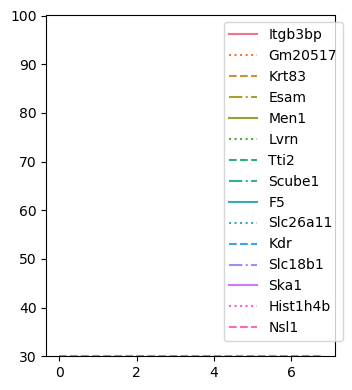

In [161]:
#also taking into account direction of fold change & plotting
colortest=sns.color_palette("husl", maxPlot)
nFCsteps=int((fc_thresh_rna_max-fc_thresh_rna_min)/fc_interval_rna+1)
xrange=np.arange(nFCsteps)*fc_interval_rna
for pc_i in range(dePC_d_rna):
    resDEsampling_rna_d=np.zeros((nFCsteps,skin_rna_de.shape[1]))
    
    for fc_thresh_rna_idx in range(nFCsteps):
        print(fc_thresh_rna_idx)
        resLogFC={0:np.array([]),-1:np.array([]),1:np.array([])}
        resNames={0:np.array([]).astype(str),-1:np.array([]).astype(str),1:np.array([]).astype(str)}
        resAgreement={0:np.array([]).astype(str),-1:np.array([]).astype(str),1:np.array([]).astype(str)}
        fc_thresh_rna=fc_thresh_rna_min+fc_thresh_rna_idx*fc_interval_rna
        for h in range(nsamples):
            deRes_d_centered=deD_centered_2bins_rna[h]
            deRes_d_centered_heldout=deD_centered_2bins_heldout_rna[h]
            for deDirection in resLogFC.keys():
    #             print(deDirection)
                resNames_h_val=deRes_d_centered[pc_i][str(deDirection)].names.to_numpy()[np.logical_and(deRes_d_centered[pc_i][str(deDirection)].pvals_adj<pval_thresh,np.abs(deRes_d_centered[pc_i][str(deDirection)].logfoldchanges)>np.log2(fc_thresh_rna))]
                resValues_h_val=deRes_d_centered[pc_i][str(deDirection)].logfoldchanges.to_numpy()[np.logical_and(deRes_d_centered[pc_i][str(deDirection)].pvals_adj<pval_thresh,np.abs(deRes_d_centered[pc_i][str(deDirection)].logfoldchanges)>np.log2(fc_thresh_rna))]

                resNames_h_heldout=deRes_d_centered_heldout[pc_i][str(deDirection)].names.to_numpy()[np.logical_and(deRes_d_centered_heldout[pc_i][str(deDirection)].pvals_adj<pval_thresh,np.abs(deRes_d_centered_heldout[pc_i][str(deDirection)].logfoldchanges)>np.log2(fc_thresh_rna))]
                resValues_h_heldout=deRes_d_centered_heldout[pc_i][str(deDirection)].logfoldchanges.to_numpy()[np.logical_and(deRes_d_centered_heldout[pc_i][str(deDirection)].pvals_adj<pval_thresh,np.abs(deRes_d_centered_heldout[pc_i][str(deDirection)].logfoldchanges)>np.log2(fc_thresh_rna))]

                resNames_h,valIdx_h,heldoutIdx_h=np.intersect1d(resNames_h_val,resNames_h_heldout,return_indices=True)
                sameDir=np.equal(resValues_h_val[valIdx_h]>0,resValues_h_heldout[heldoutIdx_h]>0)
#                 print(resNames_h_val.size)
                resAgreement[deDirection]=np.concatenate((resAgreement[deDirection],resNames_h[sameDir]))
                for fidx in range(np.sum(sameDir)):
                    f=str(resNames_h[sameDir][fidx])
                    if f not in resNames[deDirection]:
                        resNames[deDirection]=np.concatenate((resNames[deDirection],[f]))
                        resLogFC[deDirection]=np.concatenate((resLogFC[deDirection],[resValues_h_val[valIdx_h[sameDir]][fidx]]))
                    else:
                        fidx_res=np.where(resNames[deDirection]==f)
                        resLogFC[deDirection][fidx_res]+=resValues_h_val[valIdx_h[sameDir]][fidx]
        for deDirection in resLogFC.keys():
            resNames_agree,resAgreement_counts=np.unique(resAgreement[deDirection],return_counts=True)

            _,d_unique_idx,countIdx=np.intersect1d(skin_rna_de.var_names,resNames_agree,return_indices=True)
            
            resDEsampling_rna_d[fc_thresh_rna_idx,d_unique_idx]+=resAgreement_counts[countIdx]
        
    
    fig, ax = plt.subplots(figsize=(5, 4))
    plotorder=np.argsort(np.sum(resDEsampling_rna_d,axis=0))
    lines=[]
    plotCount=0
    for gidx_ in range(skin_rna_de.shape[1]):
        gidx=plotorder[gidx_]

        if np.sum(resDEsampling_rna_d,axis=0)[gidx]==0:
            continue
        if gidx_>=skin_rna_de.shape[1]-maxPlot:
            c=colortest[plotCount]
            print(skin_rna_de.var_names.to_numpy()[gidx])
            line_i,=ax.plot(xrange,resDEsampling_rna_d[:,gidx],color=c,label=skin_rna_de.var_names.to_numpy()[gidx],linestyle=linestyles[plotCount%len(linestyles)])
            lines.append(line_i)
            plotCount+=1
        else:
            c='gray'
            ax.plot(xrange,resDEsampling_rna_d[:,gidx],color=c)
#         plotCount+=1
    plt.ylim(30,100)
    ax.legend(handles=lines,bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.savefig(os.path.join(plotsavepath_de_pc,'rna_'+str(pc_i)+'d_countsVSfc.pdf'))
    plt.show()

### ATAC

In [162]:
atac_symbol=pd.read_csv('/data/xinyi/shareseq/skin_atac_symbol.csv',index_col=0)

In [163]:
skin_atac_de.var['symbol']=atac_symbol.to_numpy()[skin_atac_de.var['index']]

In [164]:
atac_allAnno=pd.read_csv('/data/xinyi/shareseq/skin_atac_allAnnotations.csv',index_col=0)
import re
atac_gPos=np.repeat(None,atac_allAnno.shape[0])
atac_anno=np.array(atac_allAnno['annotation'])
for i in range(atac_allAnno.shape[0]):
    atac_gPos[i]=str(re.sub("[\(\[].*?[\)\]]", "", atac_anno[i]))
skin_atac_de.var['gPos']=atac_gPos[skin_atac_de.var['index']]


In [165]:
pval_thresh=0.05
fc_thresh_atac_min=3
fc_thresh_atac_max=9.8
fc_interval_atac=0.2

maxPlot=15
minCount=0

dePC_shared_atac=20
dePC_d_atac=10

0
2720
12695
2286
1
2622
11130
1807
2
2553
9845
1433
3
2470
8787
1156
4
2351
7937
904
5
2256
7241
732
6
2196
6650
580
7
2151
6077
462
8
2102
5610
375
9
1977
5187
314
10
1870
4812
246
11
1760
4451
207
12
1653
4139
158
13
1578
3894
127
14
1499
3652
106
15
1444
3412
91
16
1400
3205
74
17
1358
3037
58
18
1324
2858
48
19
1296
2702
44
20
1265
2553
36
21
1243
2433
29
22
1221
2327
22
23
1204
2235
20
24
1189
2155
13
25
1178
2078
9
26
1169
2009
8
27
1159
1922
6
28
1152
1840
5
29
1144
1772
5
30
1136
1702
5
31
1133
1660
5
32
1128
1607
5
33
1123
1561
4
34
1119
1515
3
Hemgn
Chchd3
Nploc4
Lnx2
Adgrl2
Zfp608
Ube2u
Tbc1d7
Eya1
Tcf4
1700024I08Rik
Tenm4
Kat2b
Lbh
Plcxd3


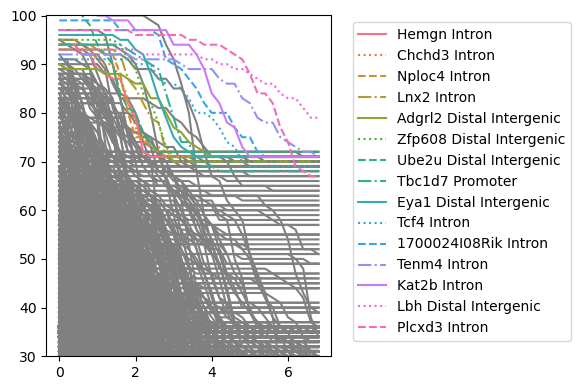

0
288
2477
10095
1
280
2146
9264
2
276
1896
8517
3
268
1671
7819
4
253
1479
7219
5
243
1365
6659
6
228
1259
6154
7
218
1148
5713
8
209
1066
5287
9
192
995
4926
10
184
925
4603
11
174
857
4271
12
168
791
3986
13
161
751
3714
14
157
715
3460
15
147
680
3224
16
146
651
3007
17
138
620
2830
18
128
591
2648
19
125
564
2498
20
118
540
2358
21
116
501
2221
22
106
474
2102
23
101
449
1985
24
96
432
1884
25
92
410
1791
26
87
386
1705
27
84
373
1626
28
82
353
1549
29
80
345
1463
30
77
328
1404
31
75
308
1337
32
71
299
1281
33
67
291
1232
34
64
284
1193
Atp6v1c2
Gm6551
Etv6
Cited2
Filip1l
Aldoart1
Wwtr1
Rbms3
Fut4
Bcl2l11
Scnn1a
Trio
Krt1
Emc7
Ldlrad3


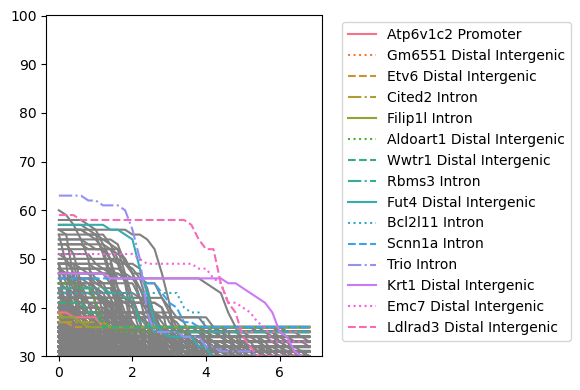

0
210
4954
5689
1
206
4558
5140
2
202
4188
4639
3
199
3882
4211
4
194
3576
3856
5
190
3301
3516
6
184
3034
3237
7
179
2842
2988
8
177
2644
2777
9
169
2495
2600
10
162
2344
2426
11
155
2180
2274
12
151
2043
2133
13
147
1922
1996
14
136
1826
1866
15
133
1730
1758
16
130
1652
1673
17
125
1582
1590
18
120
1509
1512
19
114
1443
1432
20
112
1374
1355
21
109
1318
1297
22
103
1276
1249
23
97
1226
1194
24
94
1179
1123
25
89
1121
1085
26
87
1084
1046
27
81
1055
1019
28
79
1009
982
29
76
977
944
30
73
947
907
31
68
929
881
32
65
902
856
33
65
874
835
34
62
846
814
Dapk1
Hhip
Mtx2
Pde4b
Smarca2
Plscr4
Klhl6
Plbd1
Mef2c
Ak8
Usp3
Noct
Olfm2
Osgin1
Vim


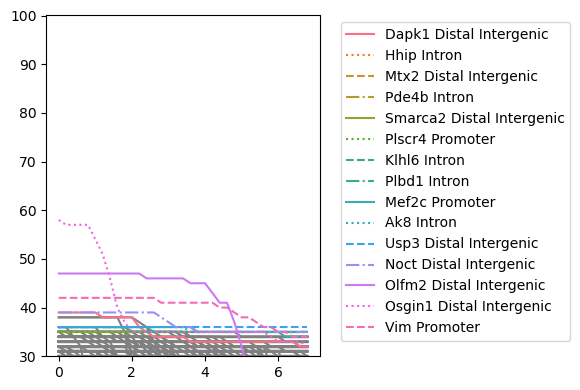

0
7
7596
9567
1
7
7413
9294
2
7
7223
9071
3
7
7034
8780
4
7
6770
8499
5
7
6570
8268
6
7
6420
8086
7
6
6301
7903
8
6
6139
7617
9
5
5909
7276
10
5
5697
7002
11
4
5476
6769
12
3
5277
6545
13
3
5102
6323
14
3
4919
6168
15
2
4753
6013
16
2
4634
5859
17
2
4516
5749
18
1
4403
5629
19
1
4326
5518
20
1
4242
5418
21
1
4169
5328
22
1
4109
5254
23
1
4035
5184
24
1
3980
5119
25
1
3934
5059
26
1
3895
4994
27
1
3866
4944
28
1
3839
4904
29
1
3818
4861
30
1
3793
4829
31
1
3767
4791
32
1
3739
4767
33
1
3717
4742
34
1
3693
4719
Vav3
Fblim1
Crim1
Srsf11
Frmd6
Npas4
Tbc1d30
Kcnj2
Rdh12
Daam1
Mir100hg
A530013C23Rik
Rars
Plekhg5
Fancc


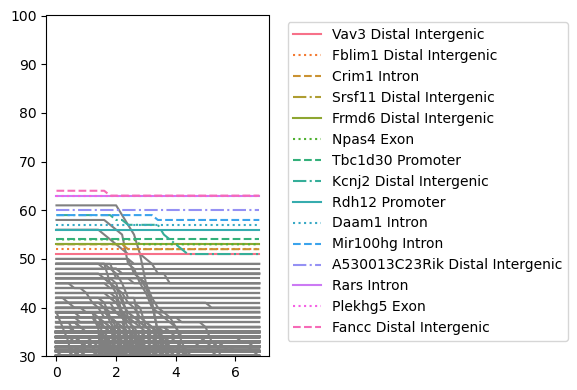

0
10
14022
14149
1
10
13653
13779
2
10
13407
13469
3
9
12992
13070
4
9
12599
12639
5
9
12263
12307
6
9
12010
12047
7
9
11783
11834
8
8
11349
11414
9
8
10896
10957
10
8
10499
10563
11
8
10131
10203
12
8
9817
9863
13
8
9554
9571
14
7
9288
9308
15
7
9068
9069
16
6
8870
8859
17
6
8674
8671
18
6
8495
8499
19
6
8345
8348
20
6
8213
8204
21
6
8107
8076
22
5
8000
7971
23
3
7902
7881
24
3
7819
7790
25
3
7746
7703
26
2
7686
7638
27
2
7632
7562
28
2
7582
7524
29
2
7530
7482
30
2
7481
7439
31
2
7446
7394
32
2
7408
7359
33
2
7373
7330
34
2
7348
7305
Ddx10
Slc31a1
Dlgap4
Filip1l
Plcd3
H3f3b
Cry2
Mir138-1
BC006965
Plet1
Sdr9c7
Cspg5
Mir6390
Kif18a
Egr2


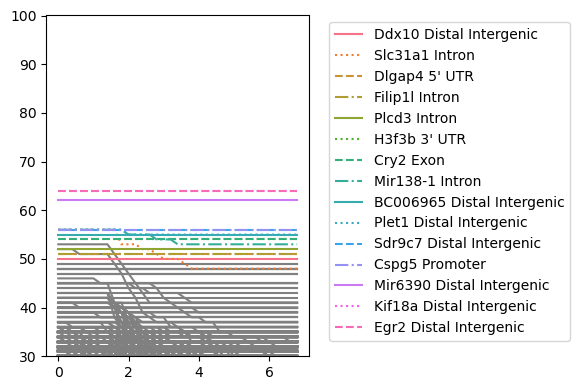

0
4
13217
10531
1
4
12932
10269
2
4
12667
10040
3
4
12289
9730
4
4
11966
9455
5
4
11731
9225
6
4
11542
9036
7
3
11314
8871
8
3
10898
8563
9
3
10513
8209
10
1
10194
7912
11
1
9873
7650
12
1
9602
7413
13
1
9355
7194
14
1
9121
7001
15
1
8949
6838
16
1
8781
6700
17
0
8637
6572
18
0
8502
6466
19
0
8386
6365
20
0
8265
6279
21
0
8183
6187
22
0
8103
6130
23
0
8029
6056
24
0
7950
6005
25
0
7889
5955
26
0
7831
5910
27
0
7787
5872
28
0
7750
5834
29
0
7710
5808
30
0
7680
5776
31
0
7654
5746
32
0
7622
5724
33
0
7584
5710
34
0
7567
5700
Calml3
BC034090
Gm13582
Barx2
Mapk15
Hadh
Smyd3
Jag1
Pard3
Ythdc1
Marcks
2310005E17Rik
Ube2z
Parva
Cables1


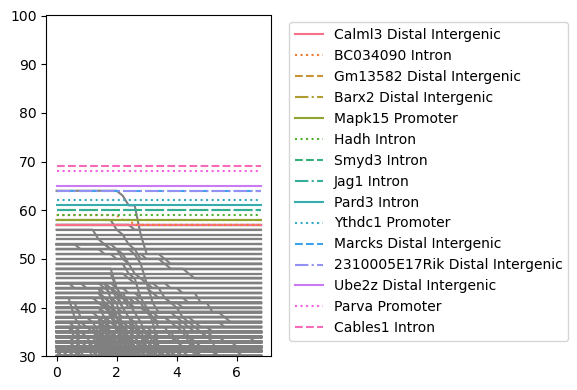

0
115
6412
5700
1
114
6184
5524
2
110
5900
5301
3
103
5692
5135
4
101
5417
4893
5
96
5161
4636
6
93
4942
4443
7
87
4754
4298
8
77
4603
4172
9
74
4445
4030
10
70
4227
3843
11
66
4033
3663
12
61
3865
3496
13
59
3693
3350
14
56
3552
3212
15
55
3406
3100
16
51
3266
2986
17
50
3142
2872
18
47
3038
2765
19
43
2937
2675
20
39
2832
2585
21
37
2748
2512
22
36
2666
2452
23
30
2587
2381
24
29
2523
2320
25
29
2474
2264
26
28
2427
2226
27
28
2370
2180
28
27
2325
2135
29
27
2267
2104
30
26
2221
2068
31
24
2178
2040
32
24
2143
2010
33
22
2121
1980
34
20
2096
1951
Fabp12
Gm20052
Ezh1
Lman1
Cdc14a
Ncf2
Mir6368
Gjb2
Cyth1
Mlxipl
Atp6v1g1
Dlx3
Gmds
Agtpbp1
Samd4


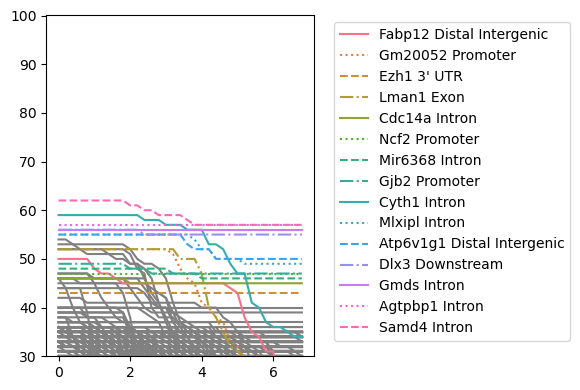

0
2
13160
11108
1
2
12933
10882
2
2
12764
10690
3
2
12493
10427
4
2
12222
10156
5
2
12012
9908
6
2
11842
9728
7
1
11675
9579
8
1
11321
9232
9
1
10986
8914
10
1
10654
8585
11
0
10391
8335
12
0
10139
8100
13
0
9932
7882
14
0
9726
7682
15
0
9562
7520
16
0
9423
7392
17
0
9268
7265
18
0
9146
7143
19
0
9026
7021
20
0
8904
6935
21
0
8806
6864
22
0
8719
6781
23
0
8640
6733
24
0
8557
6681
25
0
8499
6626
26
0
8448
6574
27
0
8393
6528
28
0
8349
6488
29
0
8302
6457
30
0
8260
6433
31
0
8227
6415
32
0
8197
6395
33
0
8167
6369
34
0
8141
6350
Gm9530
Aff1
Pbp2
2310008N11Rik
Pcdh17
Cacnb2
Atxn7l1
Susd1
Tle3
Pdlim5
Snd1
Chd7
2310022B05Rik
1110038B12Rik
Runx2


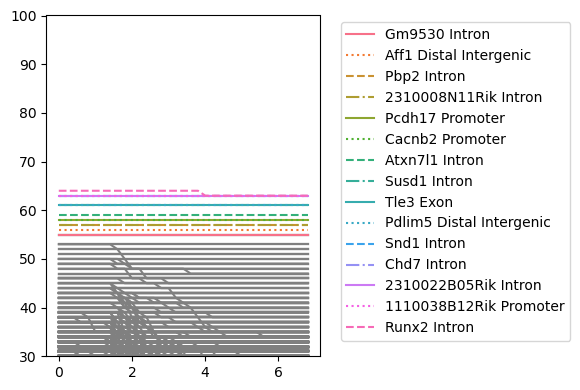

0
14
12950
16519
1
14
12743
16229
2
14
12528
15988
3
13
12288
15633
4
12
11995
15264
5
12
11708
14941
6
11
11494
14698
7
10
11319
14486
8
10
11079
14126
9
9
10785
13685
10
7
10416
13253
11
7
10092
12843
12
7
9814
12506
13
7
9554
12188
14
7
9319
11943
15
7
9115
11712
16
7
8940
11481
17
7
8763
11270
18
7
8599
11102
19
7
8444
10927
20
7
8322
10782
21
7
8214
10652
22
5
8118
10549
23
5
8017
10445
24
5
7923
10349
25
5
7857
10253
26
5
7787
10180
27
5
7716
10104
28
4
7658
10032
29
4
7610
9973
30
3
7562
9917
31
3
7520
9860
32
3
7483
9805
33
3
7449
9771
34
3
7421
9731
Rabgap1l
Atp2a2
Bcl2l10
Abhd3
Gnai3
Mtx2
Thumpd2
4930500L23Rik
Dcp1a
9130015A21Rik
Mir1951
Elk3
Krt1
Rhob
Runx2


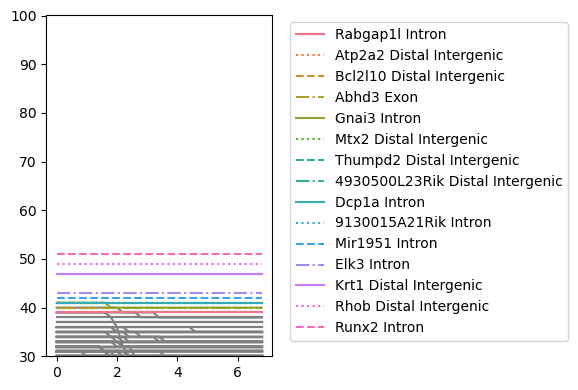

0
14
18458
18711
1
14
18170
18346
2
14
17893
18085
3
14
17512
17640
4
14
17083
17213
5
13
16744
16884
6
13
16493
16608
7
12
16236
16383
8
12
15770
15951
9
12
15269
15439
10
12
14848
14986
11
11
14450
14585
12
10
14040
14213
13
8
13726
13888
14
6
13454
13580
15
6
13204
13337
16
5
12992
13093
17
5
12762
12898
18
5
12579
12688
19
5
12429
12535
20
5
12276
12376
21
5
12137
12223
22
5
12015
12101
23
4
11896
11990
24
3
11785
11885
25
3
11691
11792
26
2
11611
11705
27
2
11533
11644
28
2
11484
11570
29
2
11418
11510
30
2
11357
11461
31
2
11305
11429
32
1
11262
11387
33
1
11223
11363
34
1
11188
11329
Dsp
Id3
Auts2
Agtpbp1
Rasa2
Smco4
Itgb5
Stac2
Ror2
Notch2
Lsm14a
Rhob
1700061F12Rik
Fancc
4930500L23Rik


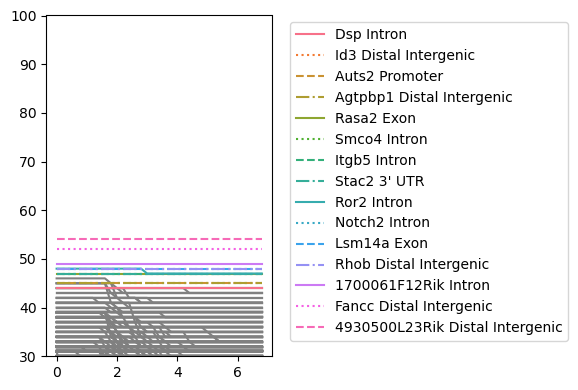

0
100
7668
9523
1
100
7436
9246
2
96
7227
8988
3
94
6979
8671
4
89
6755
8371
5
88
6503
8074
6
86
6282
7855
7
84
6082
7634
8
82
5872
7391
9
77
5665
7091
10
73
5436
6800
11
70
5196
6516
12
67
4974
6232
13
63
4775
5990
14
62
4637
5803
15
58
4487
5622
16
55
4358
5460
17
52
4239
5329
18
51
4116
5200
19
48
4028
5079
20
42
3937
4988
21
41
3847
4869
22
39
3756
4774
23
38
3693
4690
24
36
3605
4606
25
33
3549
4545
26
32
3496
4487
27
28
3443
4431
28
28
3382
4374
29
27
3347
4326
30
27
3306
4281
31
26
3261
4248
32
26
3221
4216
33
25
3179
4188
34
24
3157
4159
1110002J07Rik
Dennd1b
Cadm1
Eml4
Rhbdd1
Chd7
Pfdn4
Pcx
Gm38414
Stac2
Tusc2
Atxn1
Lmo4
Klf6
Ppp1r13l


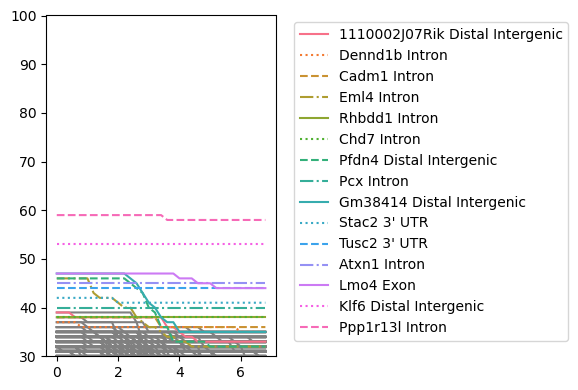

0
34
11498
11082
1
34
11273
10940
2
33
11088
10792
3
32
10820
10602
4
32
10575
10389
5
32
10371
10243
6
30
10215
10119
7
30
10026
10004
8
29
9751
9808
9
29
9431
9480
10
27
9144
9212
11
26
8866
8958
12
24
8660
8763
13
22
8486
8579
14
22
8300
8412
15
20
8138
8270
16
18
8001
8149
17
17
7873
8039
18
17
7761
7950
19
17
7622
7852
20
17
7524
7759
21
16
7454
7684
22
16
7366
7623
23
12
7291
7573
24
11
7235
7530
25
11
7186
7483
26
11
7142
7443
27
10
7105
7406
28
10
7071
7375
29
10
7031
7337
30
10
7006
7314
31
10
6977
7294
32
10
6946
7282
33
10
6921
7265
34
10
6895
7251
Uchl5
Neil3
Mcc
Klf2
Gm6498
H3f3b
4930401O12Rik
Eddm3b
1110059E24Rik
Gm19589
Klrg2
Capn9
Eya1
Lsm8
Kif18a


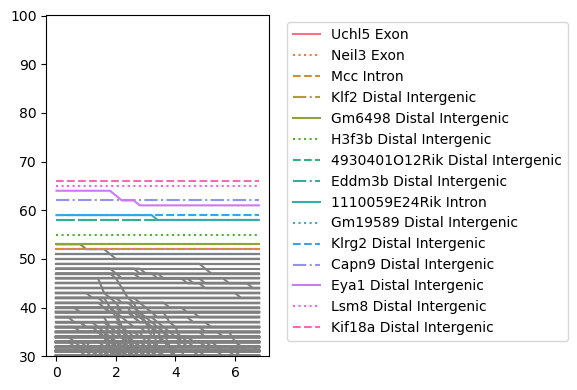

0
131
11495
13268
1
128
11212
12920
2
128
10920
12542
3
124
10651
12179
4
117
10294
11751
5
115
9969
11381
6
109
9669
11063
7
105
9413
10749
8
98
9173
10448
9
94
8905
10117
10
91
8581
9773
11
90
8270
9440
12
89
7982
9178
13
85
7736
8942
14
82
7513
8702
15
78
7299
8469
16
73
7099
8254
17
66
6942
8085
18
62
6796
7915
19
60
6669
7778
20
58
6550
7638
21
56
6438
7516
22
54
6340
7389
23
50
6241
7278
24
47
6155
7174
25
46
6068
7090
26
46
5998
7007
27
44
5947
6934
28
40
5898
6866
29
39
5834
6788
30
37
5783
6709
31
37
5739
6647
32
36
5684
6590
33
34
5643
6546
34
32
5609
6488
Arl15
Rasgrp1
Nectin1
Crocc2
Kcng1
Gpr39
Ets2
Rsrc1
Macc1
Foxq1
Mir3090
Ddah1
Lrmda
Edrf1
Rbms3


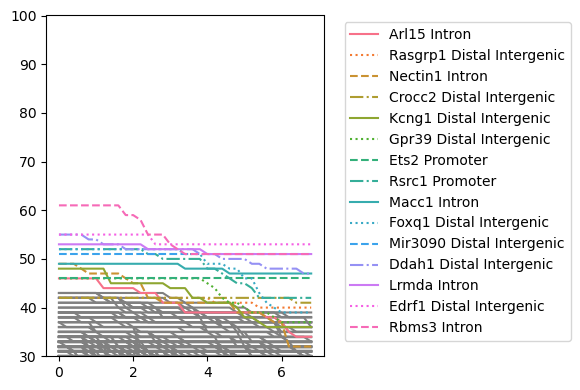

0
1
18365
16259
1
1
18099
16012
2
1
17895
15759
3
1
17522
15412
4
1
17140
15098
5
1
16867
14811
6
1
16644
14573
7
1
16336
14319
8
1
15897
13983
9
1
15437
13589
10
1
15014
13218
11
1
14632
12853
12
1
14296
12553
13
1
14024
12283
14
1
13774
12023
15
1
13518
11803
16
1
13319
11584
17
1
13141
11401
18
1
12950
11243
19
1
12795
11102
20
1
12665
10989
21
1
12561
10880
22
1
12454
10775
23
1
12367
10692
24
1
12288
10598
25
1
12215
10524
26
1
12153
10459
27
1
12091
10405
28
1
12052
10346
29
0
12013
10295
30
0
11976
10255
31
0
11939
10218
32
0
11916
10177
33
0
11887
10155
34
0
11871
10129
Asb7
Zmynd8
Jag1
Atxn1
Chd7
Tenm4
Lbh
Rps6ka4
Pofut1
Ppp1r13l
Marcks
1700044C05Rik
Gm10466
Eya1
Zfp865


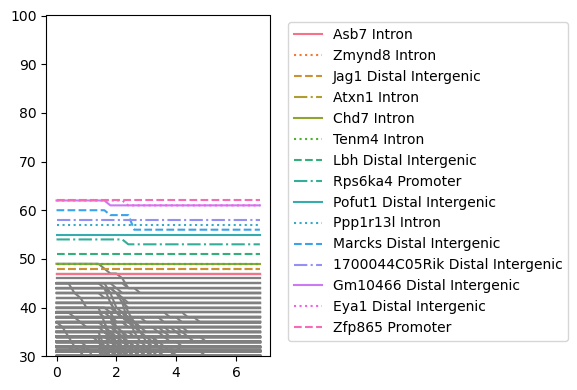

0
11
10081
9726
1
11
9923
9523
2
11
9736
9306
3
10
9547
9108
4
10
9263
8840
5
7
9020
8591
6
7
8809
8393
7
7
8657
8240
8
7
8503
8072
9
7
8253
7799
10
6
7969
7485
11
6
7696
7239
12
6
7435
6985
13
6
7229
6781
14
6
7050
6584
15
6
6857
6401
16
5
6676
6244
17
5
6526
6112
18
5
6406
5982
19
5
6303
5858
20
5
6177
5747
21
3
6085
5662
22
3
5989
5574
23
2
5906
5490
24
2
5817
5411
25
2
5737
5352
26
2
5679
5286
27
2
5636
5226
28
2
5581
5178
29
0
5537
5137
30
0
5502
5089
31
0
5457
5055
32
0
5427
5025
33
0
5392
4990
34
0
5370
4966
Adrb2
Ttc9
Hspb7
Etv6
Srgap1
Ankrd6
Cyp7a1
Gpr161
Fadd
Efnb1
Gpr156
2310016G11Rik
Vav2
Ror2
Rpa1


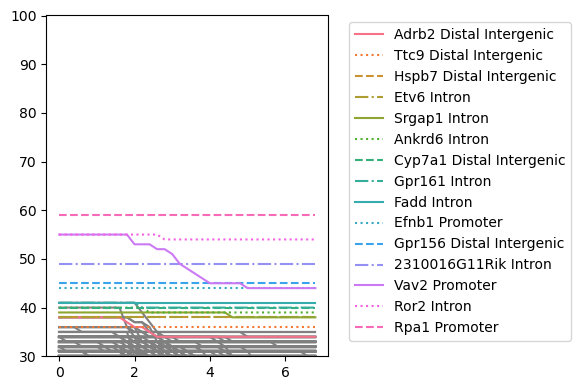

0
25
20607
18976
1
25
20281
18652
2
24
19977
18357
3
24
19565
17979
4
24
19137
17549
5
22
18757
17157
6
21
18506
16870
7
20
18261
16634
8
18
17842
16275
9
16
17315
15807
10
15
16857
15311
11
14
16401
14872
12
11
15999
14479
13
11
15633
14115
14
8
15328
13784
15
8
15088
13529
16
8
14820
13288
17
7
14601
13081
18
7
14390
12873
19
7
14193
12684
20
7
14024
12539
21
7
13867
12380
22
7
13761
12245
23
6
13628
12124
24
6
13508
12002
25
5
13411
11918
26
4
13303
11836
27
4
13213
11751
28
4
13122
11690
29
4
13054
11622
30
4
12997
11556
31
4
12938
11513
32
4
12878
11467
33
4
12839
11430
34
4
12803
11400
Zfp608
Dlx4
Kif21a
Gjb6
Vav3
Tex48
Camkmt
2310039L15Rik
Mrto4
Hlx
Zfp608
Gm10466
Pcdh17
Inpp4a
Eya1


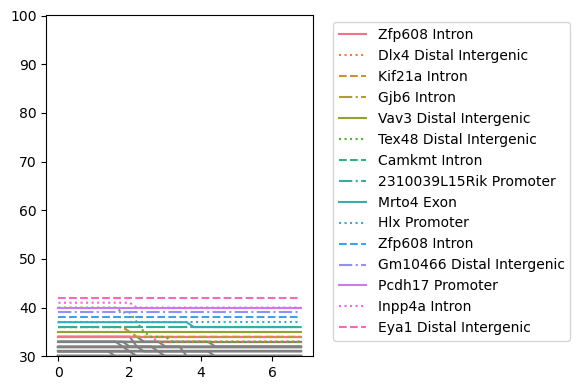

0
58
19561
20073
1
57
19287
19727
2
54
19019
19421
3
53
18688
19029
4
51
18238
18581
5
49
17924
18166
6
44
17674
17892
7
43
17454
17644
8
43
17073
17257
9
40
16598
16730
10
35
16140
16257
11
32
15723
15844
12
30
15337
15455
13
29
14963
15115
14
27
14640
14781
15
25
14354
14448
16
24
14109
14169
17
23
13851
13936
18
21
13641
13734
19
19
13458
13532
20
17
13313
13360
21
17
13153
13202
22
17
13041
13088
23
15
12907
12954
24
15
12793
12832
25
15
12711
12744
26
12
12617
12632
27
12
12542
12530
28
11
12475
12452
29
8
12412
12383
30
7
12368
12321
31
7
12312
12274
32
6
12278
12232
33
5
12236
12184
34
5
12212
12145
Tbc1d22a
Tex48
Bmpr1a
Thbs3
Zdhhc17
Hdac4
Smoc2
4930405J17Rik
Grik4
Pcdh17
Susd1
Syde2
Klf2
Zfp608
Eya1


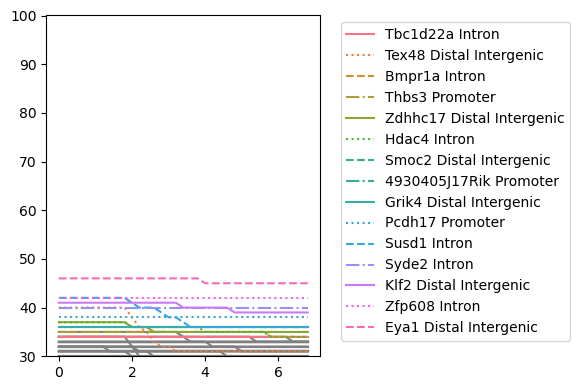

0
33
19358
19510
1
32
18995
19166
2
32
18663
18862
3
31
18240
18504
4
31
17826
18033
5
29
17437
17695
6
28
17122
17367
7
26
16850
17108
8
23
16419
16728
9
21
15895
16220
10
19
15461
15773
11
19
15060
15326
12
17
14719
14927
13
15
14398
14617
14
14
14098
14289
15
13
13809
14026
16
13
13558
13778
17
10
13325
13524
18
10
13110
13320
19
10
12921
13111
20
10
12759
12949
21
8
12615
12790
22
8
12475
12656
23
7
12334
12533
24
7
12235
12431
25
7
12127
12347
26
7
12018
12254
27
7
11929
12181
28
7
11851
12110
29
6
11792
12049
30
6
11734
12001
31
6
11675
11946
32
6
11623
11896
33
6
11567
11850
34
6
11515
11816
Ckap4
Ppp1r13l
Ndufa8
Grhl1
Armc2
Atxn2
Slc35g1
Ptpn13
Pnrc2
Sall4
Gtf2a1
Ppa2
Eya1
Kif21a
Fam43a


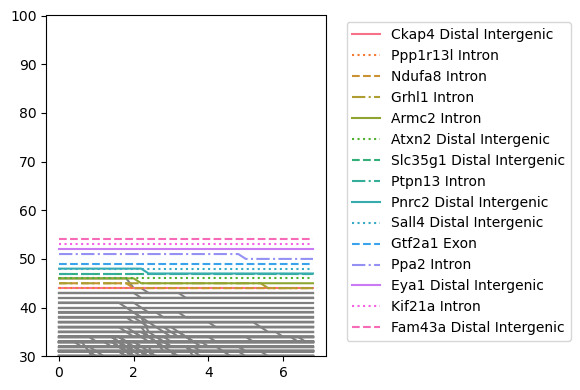

0
8
17815
16126
1
8
17462
15870
2
8
17192
15602
3
8
16842
15331
4
8
16456
14957
5
7
16132
14652
6
7
15875
14409
7
7
15653
14220
8
7
15266
13963
9
7
14794
13525
10
7
14331
13136
11
7
13921
12755
12
7
13552
12407
13
7
13209
12115
14
6
12911
11819
15
6
12649
11578
16
4
12415
11334
17
4
12212
11123
18
4
12001
10938
19
4
11829
10761
20
3
11662
10621
21
3
11532
10500
22
3
11406
10369
23
3
11291
10242
24
3
11187
10143
25
3
11088
10060
26
3
11001
9985
27
3
10930
9928
28
3
10857
9861
29
3
10780
9794
30
3
10715
9748
31
3
10674
9708
32
3
10629
9680
33
3
10576
9648
34
3
10530
9620
Tab2
Rasgef1b
Tle3
Mllt3
Mtbp
Cdc5l
Gm10466
Bfsp1
Dlg5
Atg9b
Auts2
4933412O06Rik
Vdac2
Apob
Farp1


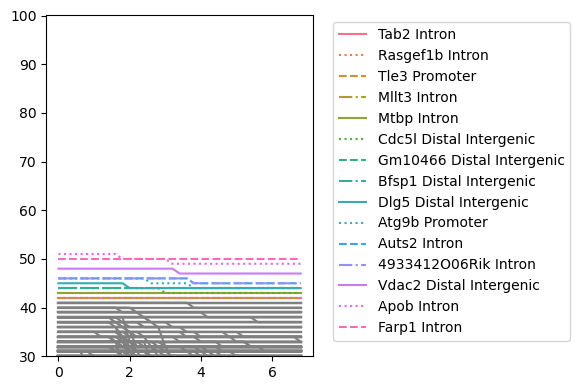

0
2
12750
11454
1
2
12560
11241
2
2
12398
11039
3
2
12167
10800
4
2
11923
10518
5
2
11734
10307
6
2
11558
10134
7
2
11417
9998
8
1
11189
9788
9
1
10812
9461
10
1
10523
9158
11
1
10219
8903
12
1
9970
8658
13
1
9727
8410
14
1
9519
8226
15
1
9343
8034
16
1
9191
7897
17
1
9059
7777
18
1
8934
7655
19
1
8802
7523
20
1
8687
7420
21
1
8590
7323
22
1
8501
7242
23
1
8425
7177
24
1
8354
7102
25
1
8295
7035
26
1
8235
6986
27
1
8181
6939
28
1
8143
6906
29
1
8110
6875
30
1
8080
6848
31
1
8046
6824
32
1
8013
6790
33
1
7994
6771
34
1
7963
6751
Slc24a2
Nhsl1
Tomm70a
Prtn3
Mcl1
Lamb1
Ltbp4
Cracdl
Gm49890
Gmds
Dach1
Osbp
Mir3074-1
Cnga4
Nfe2l2


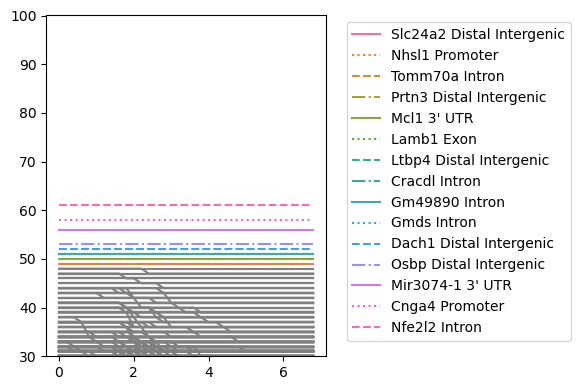

In [166]:
#also taking into account direction of fold change & plotting
colortest=sns.color_palette("husl", maxPlot)
nFCsteps=int((fc_thresh_atac_max-fc_thresh_atac_min)/fc_interval_atac+1)
xrange=np.arange(nFCsteps)*fc_interval_atac
for pc_i in range(dePC_shared_atac):
    resDEsampling_atac_shared=np.zeros((nFCsteps,skin_atac_de.shape[1]))
    
    for fc_thresh_atac_idx in range(nFCsteps):
        print(fc_thresh_atac_idx)
        resLogFC={0:np.array([]),-1:np.array([]),1:np.array([])}
        resNames={0:np.array([]).astype(str),-1:np.array([]).astype(str),1:np.array([]).astype(str)}
        resAgreement={0:np.array([]).astype(str),-1:np.array([]).astype(str),1:np.array([]).astype(str)}
        fc_thresh_atac=fc_thresh_atac_min+fc_thresh_atac_idx*fc_interval_atac
        for h in range(nsamples):
            deRes_shared_centered=deShared_centered_2bins_atac[h]
            deRes_shared_centered_heldout=deShared_centered_2bins_heldout_atac[h]
            for deDirection in resLogFC.keys():
                if str(deDirection) not in deRes_shared_centered[pc_i].keys():
                    continue
                if str(deDirection) not in deRes_shared_centered_heldout[pc_i].keys():
                    continue
#                 print('deDirec',deDirection)
                resNames_h_val=deRes_shared_centered[pc_i][str(deDirection)].names.to_numpy()[np.logical_and(deRes_shared_centered[pc_i][str(deDirection)].pvals_adj<pval_thresh,np.abs(deRes_shared_centered[pc_i][str(deDirection)].logfoldchanges)>np.log2(fc_thresh_atac))]
                resValues_h_val=deRes_shared_centered[pc_i][str(deDirection)].logfoldchanges.to_numpy()[np.logical_and(deRes_shared_centered[pc_i][str(deDirection)].pvals_adj<pval_thresh,np.abs(deRes_shared_centered[pc_i][str(deDirection)].logfoldchanges)>np.log2(fc_thresh_atac))]

                resNames_h_heldout=deRes_shared_centered_heldout[pc_i][str(deDirection)].names.to_numpy()[np.logical_and(deRes_shared_centered_heldout[pc_i][str(deDirection)].pvals_adj<pval_thresh,np.abs(deRes_shared_centered_heldout[pc_i][str(deDirection)].logfoldchanges)>np.log2(fc_thresh_atac))]
                resValues_h_heldout=deRes_shared_centered_heldout[pc_i][str(deDirection)].logfoldchanges.to_numpy()[np.logical_and(deRes_shared_centered_heldout[pc_i][str(deDirection)].pvals_adj<pval_thresh,np.abs(deRes_shared_centered_heldout[pc_i][str(deDirection)].logfoldchanges)>np.log2(fc_thresh_atac))]

                resNames_h,valIdx_h,heldoutIdx_h=np.intersect1d(resNames_h_val,resNames_h_heldout,return_indices=True)
                sameDir=np.equal(resValues_h_val[valIdx_h]>0,resValues_h_heldout[heldoutIdx_h]>0)
#                 print(resNames_h.size)
                resAgreement[deDirection]=np.concatenate((resAgreement[deDirection],resNames_h[sameDir]))
                for fidx in range(np.sum(sameDir)):
                    f=str(resNames_h[sameDir][fidx])
                    if f not in resNames[deDirection]:
                        resNames[deDirection]=np.concatenate((resNames[deDirection],[f]))
                        resLogFC[deDirection]=np.concatenate((resLogFC[deDirection],[resValues_h_val[valIdx_h[sameDir]][fidx]]))
                    else:
                        fidx_res=np.where(resNames[deDirection]==f)
                        resLogFC[deDirection][fidx_res]+=resValues_h_val[valIdx_h[sameDir]][fidx]
        for deDirection in resLogFC.keys():
            resNames_agree,resAgreement_counts=np.unique(resAgreement[deDirection],return_counts=True)
#             resNames_agree=resNames_agree[resAgreement_counts>=minAgreement]
            print(resNames_agree.size)
            _,shared_unique_idx,countIdx=np.intersect1d(skin_atac_de.var_names,resNames_agree,return_indices=True)
            
#             updateIdx
#             resDEsampling_atac_shared[fc_thresh_atac_idx,shared_unique_idx]=np.maximum(resAgreement_counts[countIdx],resDEsampling_atac_shared[fc_thresh_atac_idx,shared_unique_idx])
            resDEsampling_atac_shared[fc_thresh_atac_idx,shared_unique_idx]+=resAgreement_counts[countIdx]
    
    fig, ax = plt.subplots(figsize=(6, 4))
    plotorder=np.argsort(np.sum(resDEsampling_atac_shared,axis=0))
    lines=[]
    plotCount=0
    for gidx_ in range(skin_atac_de.shape[1]):
        gidx=plotorder[gidx_]

        if np.sum(resDEsampling_atac_shared,axis=0)[gidx]==0:
            continue
    #     if 'Rik' in skin_atac_de.var_names.to_numpy()[gidx]:
    #         continue
        if gidx_>=skin_atac_de.shape[1]-maxPlot:
            c=colortest[plotCount]
            print(skin_atac_de.var['symbol'][gidx])
            line_i,=ax.plot(xrange,resDEsampling_atac_shared[:,gidx],color=c,label=skin_atac_de.var['symbol'][gidx]+' '+skin_atac_de.var['gPos'][gidx],linestyle=linestyles[plotCount%len(linestyles)])
            lines.append(line_i)
            plotCount+=1
        else:
            c='gray'
            ax.plot(xrange,resDEsampling_atac_shared[:,gidx],color=c)
#         plotCount+=1
    plt.ylim(30,100)
    ax.legend(handles=lines,bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.savefig(os.path.join(plotsavepath_de_pc,'atac_'+str(pc_i)+'shared_countsVSfc.pdf'))
    plt.show()


In [123]:
np.sum(np.sum(resDEsampling_atac_shared,axis=0)!=0)

6884

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
Capns2
Shf
Exph5
Rbfox2
Tbc1d1
Cradd
Asap1
1700057H15Rik
Srp19
1700012I11Rik
Heyl
Jmjd1c
Crppa
Slc14a2
Dbt


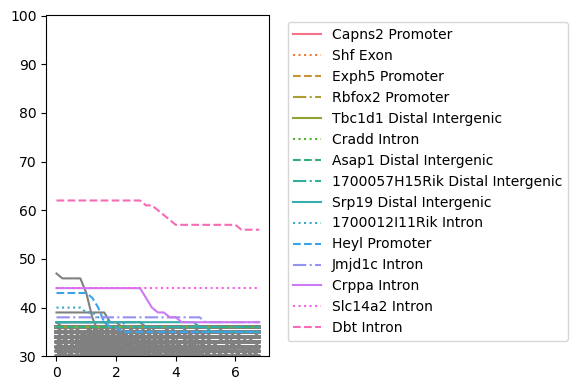

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
Peli2
Mid1
Mir7228
Gpx7
Osbpl3
Slc35f5
Itga8
Chd9
Chd7
Ptbp2
Aopep
Inppl1
Erbin
Bmp3
Rnd3


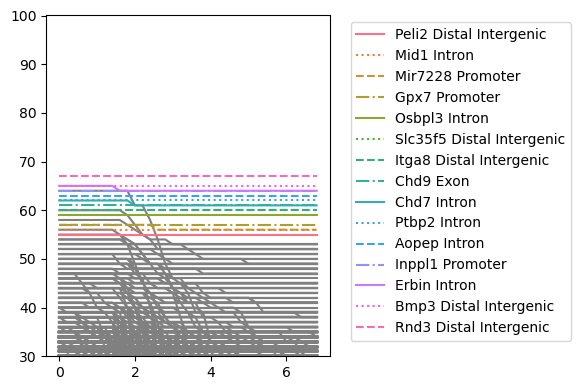

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
Gm12505
Tas2r126
Knop1
Lpar3
Gm12610
Bcr
BC048644
Bmp3
Nrip1
Insig2
2310008N11Rik
Plk2
Ccdc97
Gng5-ps
Steap4


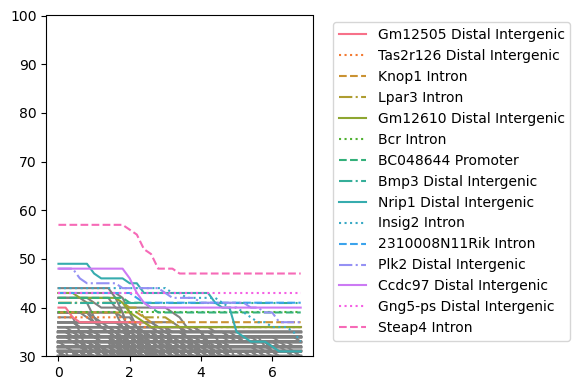

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
Lbx1
Rapgef5
Mir5130
Gm8709
Daam1
Gja1
Zmynd8
5730403I07Rik
Susd1
Txndc8
Rpl11
Klf12
Cdc14a
Pcdh7
Fem1a


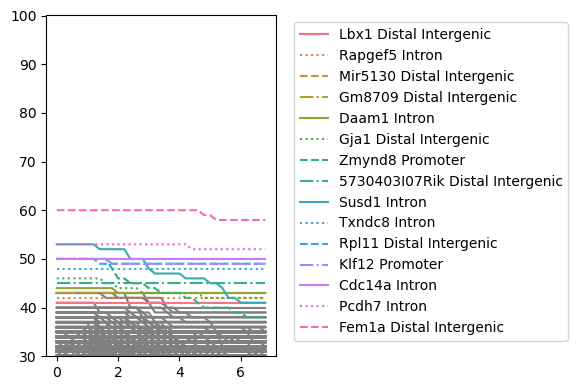

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
Klhdc2
Wfdc11
Slc24a3
Chst15
Sh3bp4
Slc31a1
Trappc8
Disp1
4732490B19Rik
Zfp362
Alas1
8030474K03Rik
Cyp2t4
Cpa5
Rc3h1


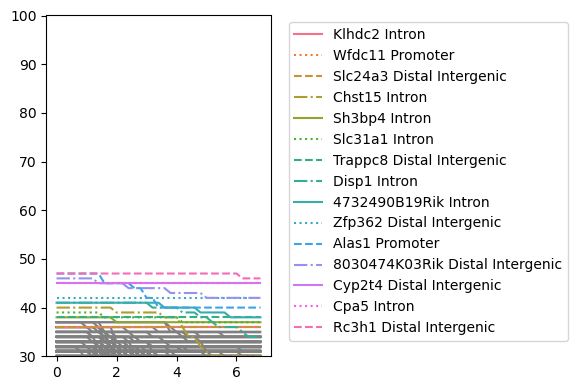

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
Elac2
Mllt3
Frmd4b
Rad51b
Kcnj2
Ccdc14
Ltbp1
Ehd4
Pam
Gm7550
Tle3
Gpld1
Rabif
Vsig8
Socs3


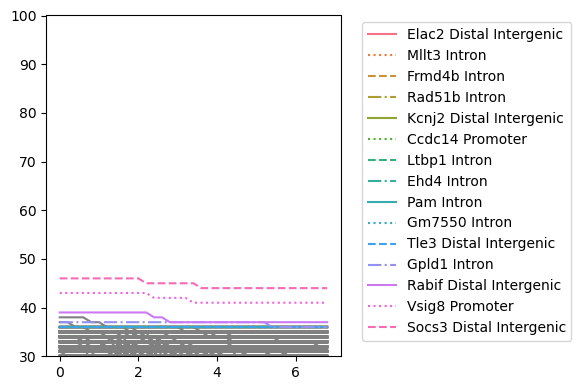

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
Slc22a7
Ptn
Prelp
Tank
Mtss1
Thrb
Clic5
Vav3
Cdk15
Gm17634
Gm10415
Acad9
Tmem131l
2310008N11Rik
Nfkbiz


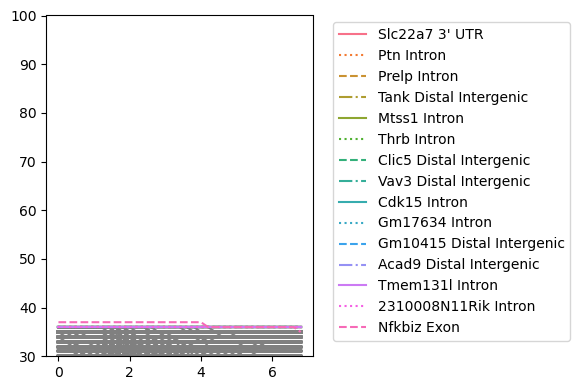

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
Foxl1
Tent5a
Bcl2l10
Lman1
Gm34184
Bzw1
Prag1
Poln
Zfp827
Maf
Ky
Rasgrp1
4930526H09Rik
Marchf8
2310008N11Rik


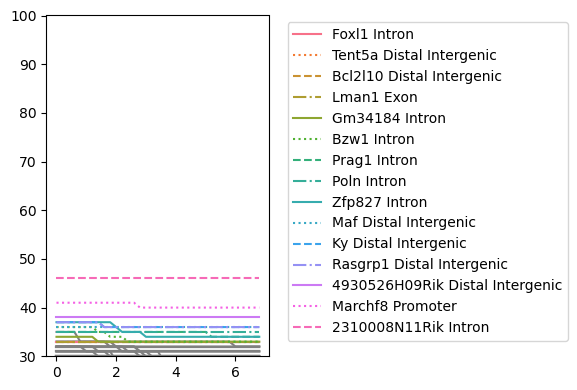

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
Rnf185
Bcl2l10
Rasgrp1
Ece1
Strip1
Tenm4
Lman1
Tnfrsf11b
Tent5a
Prag1
Marchf8
2310008N11Rik
4930526H09Rik
E230016M11Rik
Foxl1


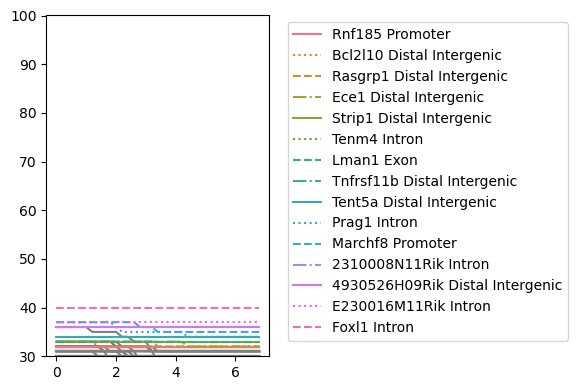

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
Pim3
Aacs
Iqck
Upp2
Ubn2
BB123696
Lgals7
Chst15
2310043O21Rik
Hbs1l
Vmn1r2
1700025G04Rik
Tmem184a
Med13
Lyzl1


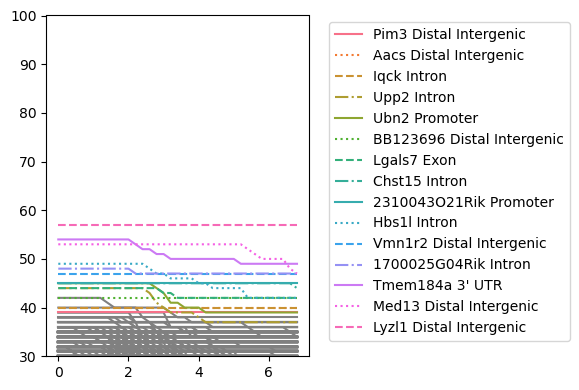

In [167]:
#also taking into account direction of fold change & plotting
colortest=sns.color_palette("husl", maxPlot)
nFCsteps=int((fc_thresh_atac_max-fc_thresh_atac_min)/fc_interval_atac+1)
xrange=np.arange(nFCsteps)*fc_interval_atac
for pc_i in range(dePC_d_atac):
    resDEsampling_atac_d=np.zeros((nFCsteps,skin_atac_de.shape[1]))
    
    for fc_thresh_atac_idx in range(nFCsteps):
        print(fc_thresh_atac_idx)
        resLogFC={0:np.array([]),-1:np.array([]),1:np.array([])}
        resNames={0:np.array([]).astype(str),-1:np.array([]).astype(str),1:np.array([]).astype(str)}
        resAgreement={0:np.array([]).astype(str),-1:np.array([]).astype(str),1:np.array([]).astype(str)}
        fc_thresh_atac=fc_thresh_atac_min+fc_thresh_atac_idx*fc_interval_atac
        for h in range(nsamples):
            deRes_d_centered=deD_centered_2bins_atac[h]
            deRes_d_centered_heldout=deD_centered_2bins_heldout_atac[h]
            for deDirection in resLogFC.keys():
    #             print(deDirection)
                if str(deDirection) not in deRes_d_centered[pc_i].keys():
                    continue
                if str(deDirection) not in deRes_d_centered_heldout[pc_i].keys():
                    continue
                resNames_h_val=deRes_d_centered[pc_i][str(deDirection)].names.to_numpy()[np.logical_and(deRes_d_centered[pc_i][str(deDirection)].pvals_adj<pval_thresh,np.abs(deRes_d_centered[pc_i][str(deDirection)].logfoldchanges)>np.log2(fc_thresh_atac))]
                resValues_h_val=deRes_d_centered[pc_i][str(deDirection)].logfoldchanges.to_numpy()[np.logical_and(deRes_d_centered[pc_i][str(deDirection)].pvals_adj<pval_thresh,np.abs(deRes_d_centered[pc_i][str(deDirection)].logfoldchanges)>np.log2(fc_thresh_atac))]

                resNames_h_heldout=deRes_d_centered_heldout[pc_i][str(deDirection)].names.to_numpy()[np.logical_and(deRes_d_centered_heldout[pc_i][str(deDirection)].pvals_adj<pval_thresh,np.abs(deRes_d_centered_heldout[pc_i][str(deDirection)].logfoldchanges)>np.log2(fc_thresh_atac))]
                resValues_h_heldout=deRes_d_centered_heldout[pc_i][str(deDirection)].logfoldchanges.to_numpy()[np.logical_and(deRes_d_centered_heldout[pc_i][str(deDirection)].pvals_adj<pval_thresh,np.abs(deRes_d_centered_heldout[pc_i][str(deDirection)].logfoldchanges)>np.log2(fc_thresh_atac))]

                resNames_h,valIdx_h,heldoutIdx_h=np.intersect1d(resNames_h_val,resNames_h_heldout,return_indices=True)
                sameDir=np.equal(resValues_h_val[valIdx_h]>0,resValues_h_heldout[heldoutIdx_h]>0)
#                 print(resNames_h_val.size)
                resAgreement[deDirection]=np.concatenate((resAgreement[deDirection],resNames_h[sameDir]))
                for fidx in range(np.sum(sameDir)):
                    f=str(resNames_h[sameDir][fidx])
                    if f not in resNames[deDirection]:
                        resNames[deDirection]=np.concatenate((resNames[deDirection],[f]))
                        resLogFC[deDirection]=np.concatenate((resLogFC[deDirection],[resValues_h_val[valIdx_h[sameDir]][fidx]]))
                    else:
                        fidx_res=np.where(resNames[deDirection]==f)
                        resLogFC[deDirection][fidx_res]+=resValues_h_val[valIdx_h[sameDir]][fidx]
        for deDirection in resLogFC.keys():
            resNames_agree,resAgreement_counts=np.unique(resAgreement[deDirection],return_counts=True)

            _,d_unique_idx,countIdx=np.intersect1d(skin_atac_de.var_names,resNames_agree,return_indices=True)
            
            resDEsampling_atac_d[fc_thresh_atac_idx,d_unique_idx]+=resAgreement_counts[countIdx]
    
    fig, ax = plt.subplots(figsize=(6, 4))
    plotorder=np.argsort(np.sum(resDEsampling_atac_d,axis=0))
    lines=[]
    plotCount=0
    for gidx_ in range(skin_atac_de.shape[1]):
        gidx=plotorder[gidx_]

        if np.sum(resDEsampling_atac_d,axis=0)[gidx]==0:
            continue
        if gidx_>=skin_atac_de.shape[1]-maxPlot:
            c=colortest[plotCount]
            print(skin_atac_de.var['symbol'][gidx])
            line_i,=ax.plot(xrange,resDEsampling_atac_d[:,gidx],color=c,label=skin_atac_de.var['symbol'][gidx]+' '+skin_atac_de.var['gPos'][gidx],linestyle=linestyles[plotCount%len(linestyles)])
            lines.append(line_i)
            plotCount+=1
        else:
            c='gray'
            ax.plot(xrange,resDEsampling_atac_d[:,gidx],color=c)
#         plotCount+=1
    plt.ylim(30,100)
    ax.legend(handles=lines,bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.savefig(os.path.join(plotsavepath_de_pc,'atac_'+str(pc_i)+'d_countsVSfc.pdf'))
    plt.show()